#Calssification for KAGGLE
- Acc = 99%
- Precdict function to be used


In [1]:
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
from PIL import Image
from numpy import asarray
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import os
import math


In [2]:
from PIL import Image
from numpy import asarray


class RoadSignDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, df, transform):
        """Initializes a dataset containing images and labels."""
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.df = df
        
    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.df)
        
    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        
        x = True
        i = 1
        while x:
            try:
                img = torchvision.datasets.folder.pil_loader(os.path.join(self.root_dir, self.df["path"][index+i%len(self.df)]))
                x =False
            except:
                i += 1
                
        if self.transform is not None:
            img = self.transform(img)
        label = self.df["class"][index]
        
        return img,label
    
# transform = transforms.Compose([transforms.Resize((64,64)), 
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.385, 0.356, 0.366],
#                                                     std=[0.289, 0.284, 0.275],)])

# transform = transforms.Compose([transforms.Resize((64,64)), 
#                                 transforms.ToTensor()])
#   transform = transforms.Compose([transforms.Resize((64,64)), 
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [3]:
headers = ["path", "class"]
df = pd.read_csv("csv/test/Train.csv")
# df = pd.read_csv("csv/test/Train_classifier_Final.csv")
# df = pd.read_csv("csv/Train_classifier_Final1.csv")
data = [df["path"],df["class"]]
trainDf = pd.concat(data, axis=1, keys=headers)

# df1 = pd.read_csv("csv/Test_classifier_Final.csv")
df1 = pd.read_csv("csv/test/Test.csv")
data = [df1["path"],df1["class"]]
testDF = pd.concat(data, axis=1, keys=headers)

# Check all files exits in the folders
count = 0


# for i in trainDf["path"]:
#     if  os.path.isfile(os.path.join("C:/Users/karim/Desktop/Train",str(i))):
#         continue
#     else:
#         count += 1

# print(count)

# for i in testDF["path"]:
#     if  os.path.isfile(os.path.join("C:/Users/karim/Desktop",str(i))):
#         continue
#     else:
#         print(i)
#         count += 1
# print(count)        

In [4]:
# TESTING NEW MEAN & STD

headers = ["path", "class"]
t = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
mean_train = 0.0
std_train = 0.0

# df_1 = trainDf.iloc[:150000,:]
# df_2 = trainDf.iloc[150000:,:240000]
# print (len(df_1["path"]))

# testset = RoadSignDataset('C:/Users/karim/Desktop/Train', df_2,transform=t)  # test directory
# loader_test = torch.utils.data.DataLoader(testset, batch_size=len(df_2["path"]), num_workers=0)#len(trainDf)
# data_test = next(iter(loader_test))
# mean_train = data_test[0].mean()
# std_train = data_test[0].std()

# print(mean_train)
# print(std_train)


# 0 to 100000
# tensor(0.3227)
# tensor(0.2810)

# 150000
# tensor(0.3373)
# tensor(0.2890)


In [5]:
# t = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor() ])
# testset = RoadSignDataset('C:/Users/karim/Desktop', testDF,transform=t)  # test directory
# loader_test = torch.utils.data.DataLoader(testset, batch_size=len(testDF), num_workers=0)#len(trainDf)
# data_test = next(iter(loader_test))

# mean_test = data_test[0].mean()
# std_test = data_test[0].std()
# data_test[0].mean(), data_test[0].std()

# print(mean_test)
# print(std_test)

#tensor(0.3653)
#tensor(0.2976)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


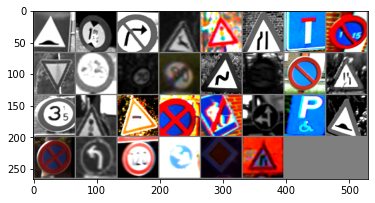

In [6]:
def show_images(img):
    img = img 
    npimg = img.numpy() * .5 + .5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

mean_test = torch.tensor(0.3653)
std_test = torch.tensor(0.2976)

transform = transforms.Compose([transforms.Resize((64,64)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean_test, std_test)])

my_dataset = RoadSignDataset('C:/Users/karim/Desktop/Train' ,trainDf,transform=transform) # training directory
my_loader = torch.utils.data.DataLoader(my_dataset, batch_size=30, shuffle=True, num_workers=0)

dataiter = iter(my_loader)
images, labels = dataiter.next()
show_images(torchvision.utils.make_grid(images))

In [15]:
n_feature = 27
output_dim = 80
learning_rate =1.0
num_epochs = 10

class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n_feature, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(self.n_feature, self.n_feature, kernel_size=5, padding=1)
        
        self.conv3 = nn.Conv2d(self.n_feature, self.n_feature*2, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(self.n_feature*2, self.n_feature*2, kernel_size=5, padding=1)
        
        self.conv5 = nn.Conv2d(self.n_feature*2, self.n_feature*4, kernel_size=5, padding=1)
        self.conv6 = nn.Conv2d(self.n_feature*4, self.n_feature*4, kernel_size=5, padding=1)
        

        self.fc4 = nn.Linear(self.n_feature*4*4*4, output_dim)

    
        self.Norm2dx1 = nn.BatchNorm2d(self.n_feature)
        self.Norm2dx2 = nn.BatchNorm2d(self.n_feature*2)
        self.Norm2dx4 = nn.BatchNorm2d(self.n_feature*4)

    def forward(self, f):
        out = self.conv1(f)
        out = F.relu(out)
        out = self.Norm2dx1(out)
#         out = self.Norm2dx1(self.Relu(self.conv1(f)))

        out = self.conv2(out)
        out = F.relu(out)
        out = self.Norm2dx1(out)
        out = F.max_pool2d(out, 2)
#         out = self.pool(self.Norm2dx1(self.Relu(self.conv2(out))))

        out = self.conv3(out)
        out = F.relu(out)
        out = self.Norm2dx2(out)
#         out = self.Norm2dx2(self.Relu(self.conv3(out)))

        out = self.conv4(out)
        out = F.relu(out)
        out = self.Norm2dx2(out)
        out = F.max_pool2d(out, 2)
#         out = self.pool(self.Norm2dx2(self.Relu(self.conv4(out))))

        out = self.conv5(out)
        out = F.relu(out)
        out = self.Norm2dx4(out)
#         out = self.Norm2dx4(self.Relu(self.conv5(out)))

        out = self.conv6(out)
        out = F.relu(out)
        out = self.Norm2dx4(out)
        out = F.max_pool2d(out, 2)
#         out = self.pool(self.Norm2dx4(self.Relu(self.conv6(out))))
        
        out = out.view(out.size(0), -1)
        
#         out = self.fc1(out)
#         out = F.relu(out)
#         out = self.dropout(out)
        
        out = self.fc4(out)
        out = F.softmax(out, dim = 1)
        
        return out


device = "cuda:0"
# device = "cpu"
# Reading inputs
mean_test = torch.tensor(0.3653)
std_test = torch.tensor(0.2976)
transform_test = transforms.Compose([transforms.Resize((64,64)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean_test,std_test)])
mean_train = torch.tensor(0.3373)
std_train = torch.tensor(0.2890)
transform_train = transforms.Compose([transforms.Resize((64,64)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean_train,std_train)])

trainset = RoadSignDataset('C:/Users/karim/Desktop/Train', trainDf, transform=transform_train)  # training directory
testset = RoadSignDataset('C:/Users/karim/Desktop', testDF,transform=transform_test)  # test directory

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, num_workers=0)


# Model
model = CNN(n_feature, output_dim)
print(model)
model.to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0)
criterion = nn.NLLLoss()  


epochs_train_loss = []
epochs_test_loss = []
accuracy_train = []
accuracy_test = []

writer = SummaryWriter(f"runs/MNIST/Classifier")
stepTrain = 0
stepTest = 0


for i in range(num_epochs):
    accuracy = 0
    tmp_loss = []
    print(i+1)
    for inputs, labels in trainloader:
        model.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        corr = ((output.argmax(dim=1) == labels).float().mean())
        accuracy += corr/len(trainloader)
        tmp_loss.append(loss.detach())

        writer.add_scalar("Training loss", loss.item(), global_step=stepTrain) # TEST loss.item()
        writer.add_scalar("Training accuracy", accuracy *100, global_step=stepTrain)
        stepTrain += 1
        
        train_loss = (sum(tmp_loss)/len(tmp_loss))

    print("TRAIN : epoch : {}  accuracy : {}%  loss : {}".format(i+1, (accuracy*100), (sum(tmp_loss)/len(tmp_loss))))
    
    epochs_train_loss.append((sum(tmp_loss)/len(tmp_loss)).cpu())
    accuracy_train.append((accuracy*100).cpu())

    with torch.no_grad():
        correct = 0
        total = 0
        tmp_loss = []
        for inputs, labels in testloader:
            model.eval()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            tmp_loss.append(loss.detach())

            writer.add_scalar("Testing loss", loss, global_step=stepTest)
            writer.add_scalar("Testing accuracy", (100 * correct / total), global_step=stepTest)
            stepTest += 1

        print("TEST : epoch : {}  accuracy : {}%  loss : {}".format(i+1,  (100 * correct / total), (sum(tmp_loss)/len(tmp_loss))))
        epochs_test_loss.append((sum(tmp_loss)/len(tmp_loss)).cpu())
        accuracy_test.append((100 * correct / total))

    checkpoint = {
        'epoch': i + 1,
        'valid_loss_min': train_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }

    torch.save(checkpoint, "backup/classifier_epoch" + str(i + 1))

plt.plot(epochs_train_loss, label="Train")
plt.plot(epochs_test_loss, label="Test")
plt.title("Loss (training & testing)")
plt.ylabel("Mean loss")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_test, label="Test")
plt.title("Accueacy (training & testing)")
plt.ylabel("Accueacy %")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()


CNN(
  (conv1): Conv2d(3, 27, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(27, 27, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(27, 54, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(54, 54, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(54, 108, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(108, 108, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc4): Linear(in_features=1728, out_features=80, bias=True)
  (Norm2dx1): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Norm2dx2): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Norm2dx4): BatchNorm2d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
1
TRAIN : epoch : 1  accuracy : 98.5661849975586%  loss : -0.9855475425720215
TEST : epoch : 1  accuracy : 91.13255226280727%  loss : -0.9069167375564575
2
TRAIN : epoch : 2  accuracy 

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "Full_model")

In [11]:
from torchinfo import summary
batch_size = 128
summary(model, input_size=(batch_size, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Conv2d: 1-1                            [128, 27, 62, 62]         2,052
├─BatchNorm2d: 1-2                       [128, 27, 62, 62]         54
├─Conv2d: 1-3                            [128, 27, 60, 60]         18,252
├─BatchNorm2d: 1-4                       [128, 27, 60, 60]         (recursive)
├─Conv2d: 1-5                            [128, 54, 28, 28]         36,504
├─BatchNorm2d: 1-6                       [128, 54, 28, 28]         108
├─Conv2d: 1-7                            [128, 54, 26, 26]         72,954
├─BatchNorm2d: 1-8                       [128, 54, 26, 26]         (recursive)
├─Conv2d: 1-9                            [128, 108, 11, 11]        145,908
├─BatchNorm2d: 1-10                      [128, 108, 11, 11]        216
├─Conv2d: 1-11                           [128, 108, 9, 9]          291,708
├─BatchNorm2d: 1-12                     

In [ ]:
 def predict(image_path,m = model):

    image = Image.open(image_path)
    transform = transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    image =  torch.unsqueeze(transform(img), 0)
    image = image.to("cuda:0")
    pred = m(image)
    return(pred.argmax(dim=1))